In [1]:
from arpes.io import load_data
from arpes.utilities.conversion import convert_to_kspace

import os.path
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import math
import numpy as np
import xarray as xr

C:\Users\fb7365\Documents\CODES\arpes\arpes\config.py:54: UserWarning: Could not find local configuration file. If you don't have one, you can safely ignore this message.
  warnings.warn(msg)


Activating auto-logging. Current session state plus future input saved.
Filename       : logs\unnamed_2023-10-16_19-22-36.log
Mode           : backup
Output logging : False
Raw input log  : False
Timestamping   : False
State          : active


In [2]:
# Define directory
path = os.path.abspath("E:/DATA/EPFL/ARPES/e19775/Box_1_square_renamed")

# Different parameters used to set up scans at SLS
scan_type = 'FS'
direction = 'N'
phi = '*'
energy = '*'
polarization = '*'
temp = '*'
e_pass = '*'+'eVpass'
comment = ''
run = '*'.zfill(4)

# Put together string for finding file
parameters = [scan_type, direction, phi, energy, polarization, temp, e_pass, comment, run]
if comment == '':
    parameters.remove(comment)
file_type = 'h5'
file_name = '_'.join(parameters)
file = '.'.join([file_name , file_type])

full_file = os.path.join(path, file)
file

'FS_N_*_*_*_*_*eVpass_000*.h5'

In [3]:
import glob
# Load all files with above specified parameters, * is a placeholder and imports all files in its place
files = glob.glob(full_file)
print('Files found: '+str(len(files)))


Files found: 15


In [4]:
data_list = {}
for file in files:
    #data_list.append(load_data(file, location="ULTRA"))
    # data = load_data(file, location="ULTRA")
    file_name = file.replace(path, '')[1:-3]
    data_list.update({file_name : '0'})

In [5]:
#! Plot section

# rows = math.ceil(len(data_list) / 2)
# fig, ax = plt.subplots(rows, 2, figsize=(14, 6*rows))
# fig.suptitle('Overview of Bi2223 FS 1. Beamtime', fontsize=20)
# for key in data_list.keys():
#     data = data_list[key].spectrum
#     fs = data.sel(eV=slice(-0.02,0.02)).sum("eV")
#     fs.plot(ax=ax.ravel()[list(data_list).index(key)])
#     ax.ravel()[list(data_list).index(key)].set_title(f"{key}")
#     plt.tight_layout(rect=[0, 0.03, 1, 0.98])

In [6]:
# correct for Fermi level from Gold samples

folder_box1 = 'E:/DATA/EPFL/ARPES/e19775/Box_1_square/'
file_box1_square = os.listdir(folder_box1)

gold_ref = [s for s in file_box1_square if 'Gold' in s ] +[s for s in file_box1_square if 'GOLD' in s ]
gold_ref = [s for s in gold_ref if not('._') in s]
    
gold_list = {}
for file in gold_ref:
    #data_list.append(load_data(file, location="ULTRA"))
    data = load_data(folder_box1+file, location="ULTRA")
    scan_name = file.replace('.h5', '')
    gold_list.update({scan_name : data})
    
    

C:\Users\admin-fb7365\AppData\Local\Temp\ipykernel_63052\2391119999.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.98])


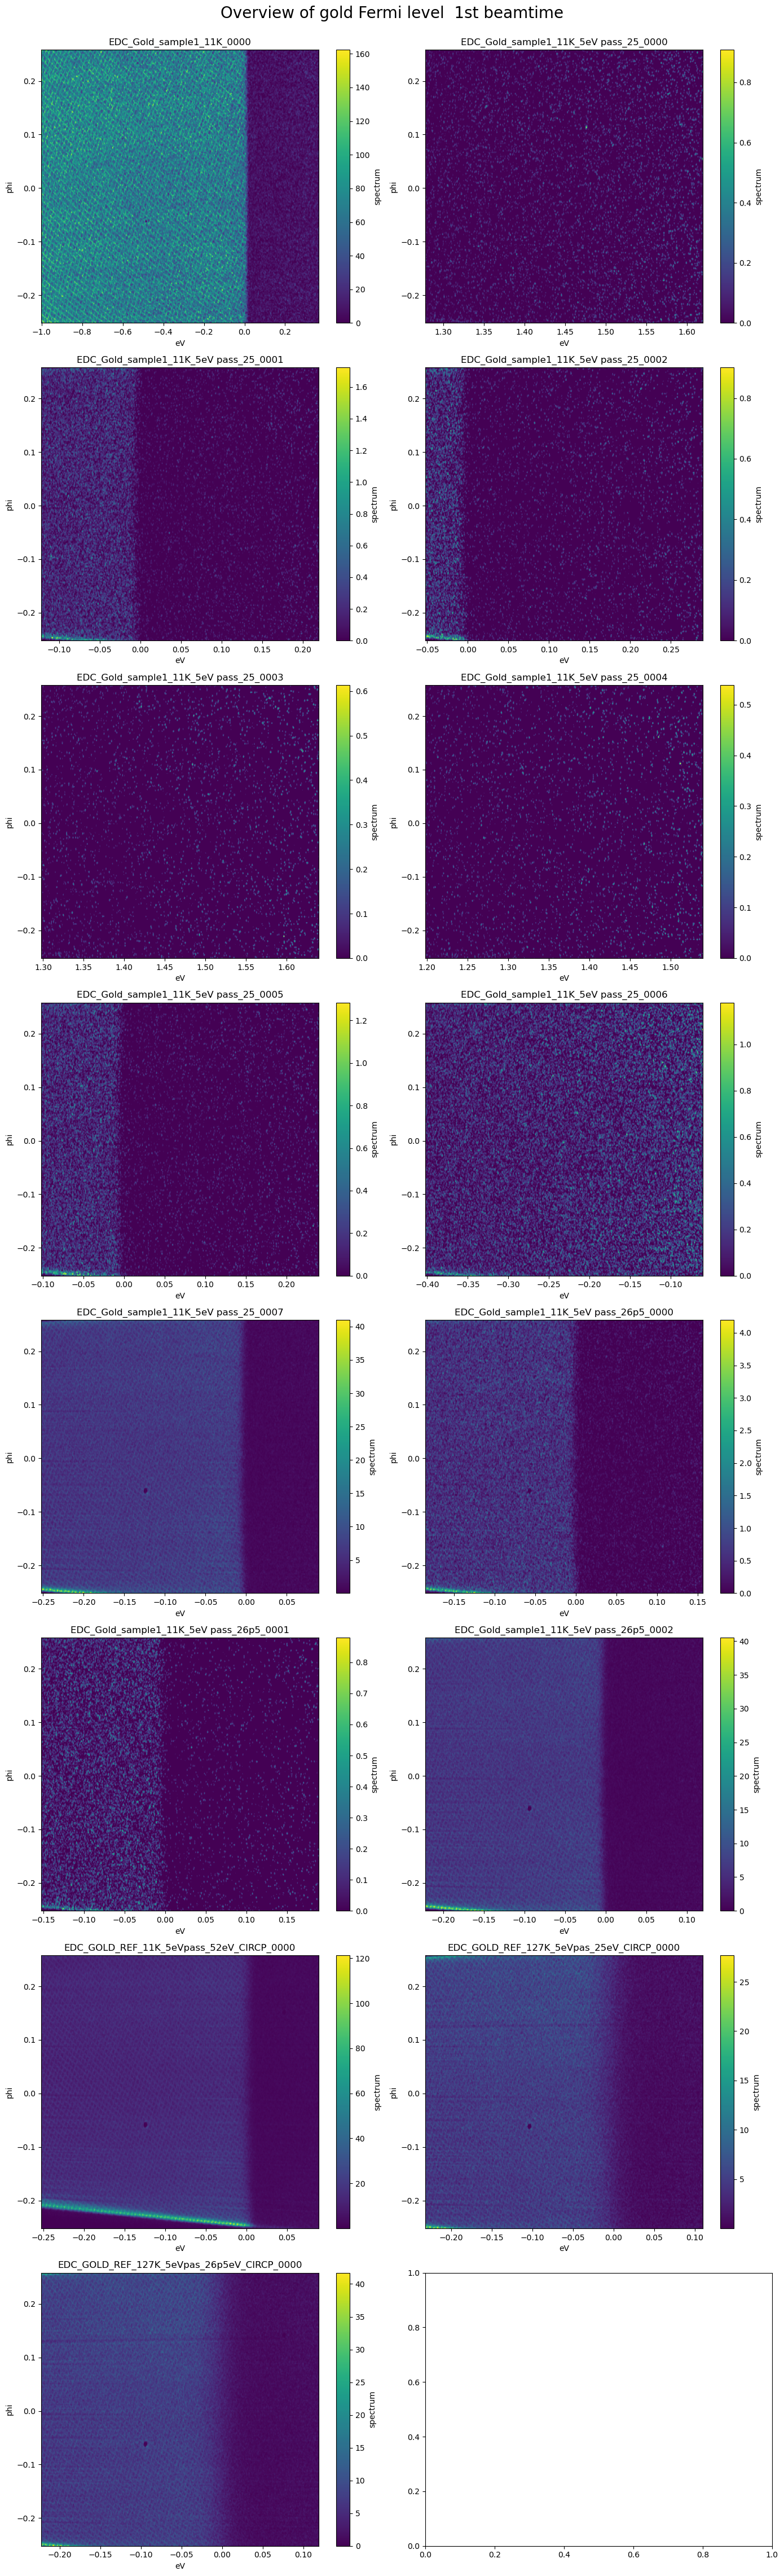

In [7]:
#! Plot section Gold EDC

rows = math.ceil(len(data_list) / 2)
fig, ax = plt.subplots(rows, 2, figsize=(14, 6*rows))
fig.suptitle('Overview of gold Fermi level  1st beamtime', fontsize=20)
for key in gold_list.keys():
    data = gold_list[key]
#     fs.plot(ax=ax.ravel()[list(gold_list).index(key)])
    data.spectrum.T.plot(ax=ax.ravel()[list(gold_list).index(key)])
    ax.ravel()[list(gold_list).index(key)].set_title(f"{key}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])

Running on multiprocessing pool... this may take a while the first time.


Fitting on pool...:   0%|          | 0/52 [00:00<?, ?it/s]

Deserializing...
Finished deserializing


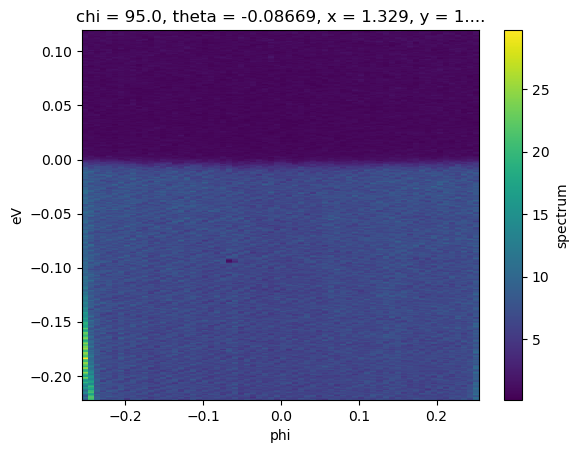

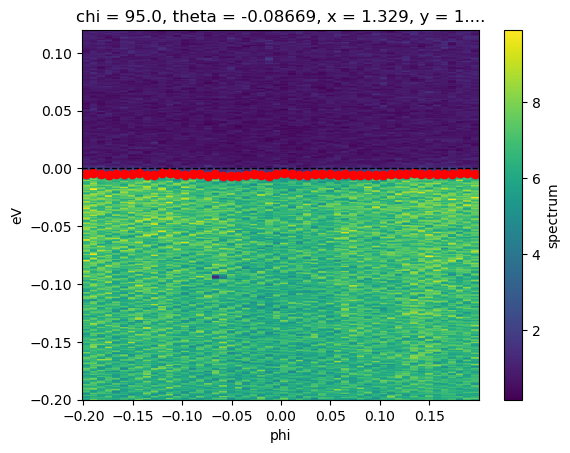

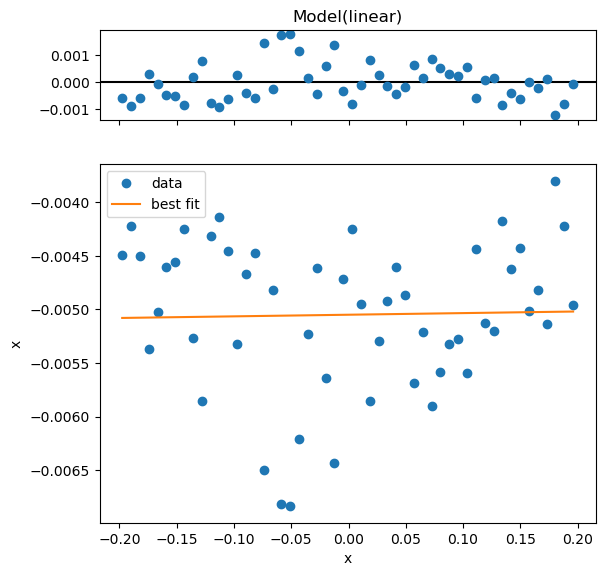

Running on multiprocessing pool... this may take a while the first time.


Fitting on pool...:   0%|          | 0/52 [00:00<?, ?it/s]

Deserializing...
Finished deserializing


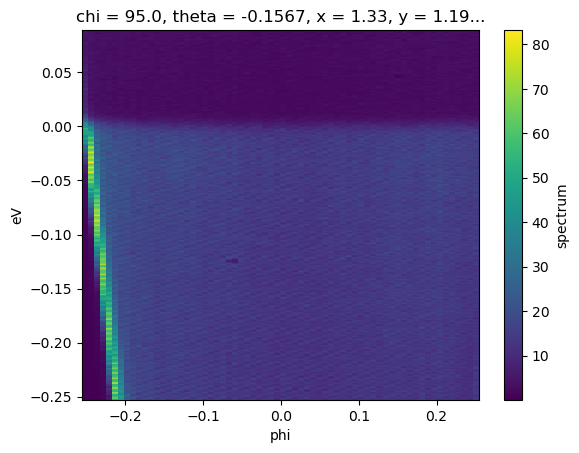

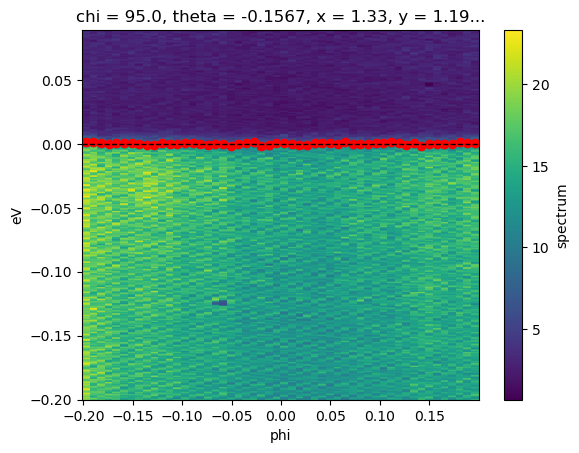

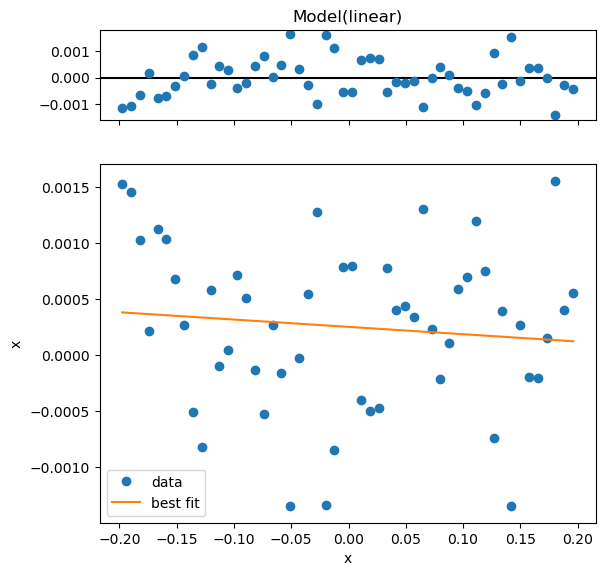

In [7]:
from arpes.analysis.general import rebin
from arpes.all import AffineBroadenedFD, broadcast_model, LinearModel

data_gold = {}
data_gold['LT'] = {} 
data_gold['HT'] = {} 
data_gold['LT']['data'] = gold_list['EDC_Gold_sample1_11K_5eV pass_26p5_0002']
data_gold['HT']['data'] = gold_list['EDC_GOLD_REF_11K_5eVpass_52eV_CIRCP_0000']

for temperature in data_gold:

    binned = rebin(data_gold[temperature]['data'], phi=10).spectrum
    fig, ax = plt.subplots()

    binned.plot(ax= ax)

    fermi_level = binned.sel(phi=slice(-0.2,0.2), eV=slice(-0.2,0.2))
    fig, ax = plt.subplots()

    fermi_level.plot(ax= ax)
    if temperature == 'HT':
        results = broadcast_model(AffineBroadenedFD, fermi_level, "phi", params={"fd_center": {"value": 0.001},
                                                         "fd_width": {"value": 0.003},
                                                         "lin_bkg" :  {"value": 200}, 
                                                         "const_bkg" :  {"value": 8e2},
                                                         "offset" :  {"value": 1e2},
                                                         })
    else:
        results = broadcast_model(AffineBroadenedFD, fermi_level, "phi")   

    ax.scatter(*results.F.p("fd_center").G.to_arrays(), color="red")
    ax.axhline(y=0, color='k', linestyle='--', linewidth=1)

    lin_mod = LinearModel().guess_fit(results.F.p("fd_center"))
    lin_mod.plot()
    data_gold[temperature]['fit_Fermi'] = lin_mod

    plt.show()

    results.F.show()

In [8]:
name_scans = list(data_list.keys())
print(name_scans)

good_scans = ['FS_N_P50_26p5eV_CIRCM_LT_10eVpass_0000',
              'FS_N_M40_26p5eV_CIRCP_LT_10eVpass_0002', 
              'FS_N_P50_26p5eV_CIRCP_HT_10eVpass_0003']


['FS_N_M42_26p5eV_LHQ_LT_5eVpass_0001', 'FS_N_P50_26p5eV_LHQ_LT_10eVpass_0000', 'FS_N_P50_26p5eV_CIRCP_HT_10eVpass_0003', 'FS_N_P50_52eV_LHQ_LT_10eVpass_0000', 'FS_N_P50_52eV_LVLE_LT_10eVpass_0000', 'FS_N_M40_26p5eV_CIRCP_LT_10eVpass_0000', 'FS_N_M40_26p5eV_CIRCP_LT_10eVpass_0001', 'FS_N_M42_26p5eV_LHQ_LT_5eVpass_0000', 'FS_N_M43_25eV_LHQ_LT_10eVpass_0000', 'FS_N_P50_26p5eV_CIRCP_HT_10eVpass_0000', 'FS_N_M43_26p5eV_LHQ_LT_10eVpass_0000', 'FS_N_P50_26p5eV_CIRCM_LT_10eVpass_0000', 'FS_N_M40_26p5eV_CIRCP_LT_10eVpass_0002', 'FS_N_P50_26p5eV_CIRCP_LT_10eVpass_0000', 'FS_N_P50_26p5eV_CIRCM_LT_10eVpass_0001']


In [81]:
bi2223_data_list = {}
for file in [good_scans[0]]:
    raw_data = load_data(path+ os.sep+ file+'.h5', location="ULTRA")
    if 'LT' in file:
        edge = data_gold['LT']['fit_Fermi'].eval(x=raw_data.spectrum.phi)
    elif 'HT' in file:
        edge = data_gold['HT']['fit_Fermi'].eval(x=raw_data.spectrum.phi)
    else:
        print('Error: find Fermi level')
    edge_xr = xr.DataArray(edge, coords={'phi': raw_data.phi}, dims=["phi"])

    corrected_data = raw_data.spectrum.G.shift_by(edge_xr, shift_axis="eV")
    k_data = convert_to_kspace(corrected_data)
    file_name = file
    bi2223_data_list.update({file_name : k_data})
    

In [11]:
scan = bi2223_data_list[good_scans[0]]



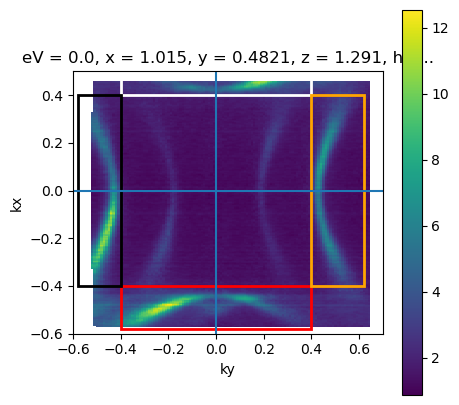

In [150]:
angle_offsets = {}
angle_offsets["Bi2223"] = {
    "phi": 0.075,    # controls the offset along the analyzer center axis
    "theta": 0,
    "chi": 49.999125,    # sample rotation, controls kx-ky plane orientation
    "alpha": 0,
    "psi": 0.04,
}


# corrected_data.S.fermi_surface.plot(ax = ax)
# fig, ax = plt.subplots()
# scan.S.fermi_surface.plot(ax = ax)
# rect_b = patches.Rectangle((-0.4, -0.58), 0.8, 0.18, linewidth=2, edgecolor='r', facecolor='none')
# rect_t = patches.Rectangle((-0.4, 0.4), 0.8, 0.18, linewidth=2, edgecolor='w', facecolor='none')
# rect_l = patches.Rectangle((-0.58, -0.4), 0.18, 0.8, linewidth=2, edgecolor='k', facecolor='none')
# rect_r = patches.Rectangle((0.4, -0.4), 0.22, 0.8, linewidth=2, edgecolor='orange', facecolor='none')


fig, ax = plt.subplots(figsize = (5,5))
example_fs = corrected_data.S.fermi_surface.copy(deep=True)
example_fs.S.apply_offsets(angle_offsets["Bi2223"] )
k_data = convert_to_kspace(
    example_fs
)
k_data.S.plot(ax = ax)

rect_b = patches.Rectangle((-0.4, -0.58), 0.8, 0.18, linewidth=2, edgecolor='r', facecolor='none')
rect_t = patches.Rectangle((-0.4, 0.4), 0.8, 0.18, linewidth=2, edgecolor='w', facecolor='none')
rect_l = patches.Rectangle((-0.58, -0.4), 0.18, 0.8, linewidth=2, edgecolor='k', facecolor='none')
rect_r = patches.Rectangle((0.4, -0.4), 0.22, 0.8, linewidth=2, edgecolor='orange', facecolor='none')
ax.add_patch(rect_b)
ax.add_patch(rect_t)
ax.add_patch(rect_l)
ax.add_patch(rect_r)
ax.axvline(0)
ax.axhline(0)

ax.set_xlim([-.6, 0.7])
ax.set_ylim([-.6, 0.5])
ax.set_aspect('equal')
plt.show()

In [84]:
corrected_data

<xarray.DataArray (eV: 961, phi: 661, beta: 120)>
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
...
        [0.01107903, 0.03388559, 0.15089904, ..., 1.69401561,
         1.27630962, 1.44182551],
        [0.03725624, 0.06084032, 0.16354474, ..., 2.03707348,
         1.91693534, 1.17703961],
        [0.18380768, 0.08445973, 0.4002993 , ..., 2.21573207,
         2.57617932, 1.23857471]],

       [[1.34011519, 1.0162064 , 1.71966435, ..., 1.47138524,
         0.85911482, 1.28148202],
        [0.83389176, 1.03252363, 1.76800047, ..., 1.41619804,
         0.85706582, 1.42929209],
        [0.69585527, 1.15937141, 1.91137483, ..., 1.41672499,
         1.0154644 , 1.45442987],
        ...,
        [0.09114448, 0.0477699 , 0.19902933, ..., 1.73852481,
         1.68357449, 1.61136934],
        [0.11439979, 0.10185661, 0.20314376, ..., 2.05871269,
         2.5826819 , 1.42439717],
        [0.2811042 , 0.18792485, 0.33965474, ..., 2.40462698,
         3.0849502 , 1.36294731]]])
Coordinates:
  * eV       (eV) float64 -0.5599 -0.5592 -0.5585 ... 0.1214 0.1221 0.1228
  * phi      (phi) float64 -0.2517 -0.2509 -0.2501 ... 0.2563 0.2571 0.2578
  * beta     (beta) float64 -0.2601 -0.2556 -0.2512 ... 0.2556 0.26 0.2644
    chi      float64 50.0
    theta    float64 -0.08731
    x        float64 1.015
    y        float64 0.4821
    z        float64 1.291
    hv       float64 26.5
    alpha    float64 0.0
    psi      float64 0.0
Attributes: (12/143)
    Acquisition Mode:                            Fixed
    Axis0.Description:                           Kinetic Energy 
    Axis0.Mode:                                  N/A
    Axis0.Scale:                                 [2.14758907e+01 7.10490000e-04]
    Axis0.ScaleType:                             Regular
    Axis0.Units:                                 eV
    ...                                          ...
    hv Record Type:                              Per scan
    hv Recording Method:                         After first sweep
    hv Units:                                    eV
    sample_workfunction:                         4.464
    spectrum_type:                               map
    chi_offset:                                  49.999125

{'chi': 49.999125}


(None, <Axes: >)

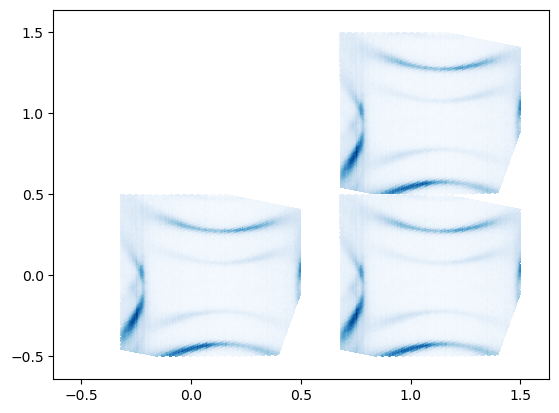

In [77]:
import pprint # pretty print
from arpes.utilities.bz import orthorhombic_cell, hex_cell_2d
from arpes.plotting.bz import overplot_standard, bz_plot, plot_data_to_bz
angle_offsets = {}
angle_offsets["Bi2223"] = {
    "phi": 0.,    # controls the offset along the analyzer center axis
    "theta": 0.0,
    "chi": 0,    # sample rotation, controls kx-ky plane orientation
    "alpha": 0.,
    "psi": 0.,
}



pprint.pprint(corrected_data.S.offsets)

example_fs = corrected_data.S.fermi_surface.copy(deep=True)

example_fs.S.apply_offsets(angle_offsets["Bi2223"] )
k_data = convert_to_kspace(
    example_fs
)

fig, ax = plt.subplots()
# ax3d = fig.add_subplot(1,1,1, projection='3d')

# bz_plot(cell=orthorhombic_cell(a=1,b=1, c=0.1), linewidth = 2, ax= ax, repeat = (2,2,1))


plot_data_to_bz(k_data, orthorhombic_cell(a=1, b=1, c=1 ), ax = ax, rotate= np.deg2rad(15),
                 scale = np.pi/3.85, shift = [0,0], bz_number = (0,0),)

plot_data_to_bz(k_data, orthorhombic_cell(a=1, b=1, c=1 ), ax = ax, rotate= np.deg2rad(15),
                 scale = np.pi/3.85, shift = [0,0], bz_number = (1,1),)
plot_data_to_bz(k_data, orthorhombic_cell(a=1, b=1, c=1 ), ax = ax, rotate= np.deg2rad(15),
                 scale = np.pi/3.85, shift = [0,0], bz_number = (1,0),)

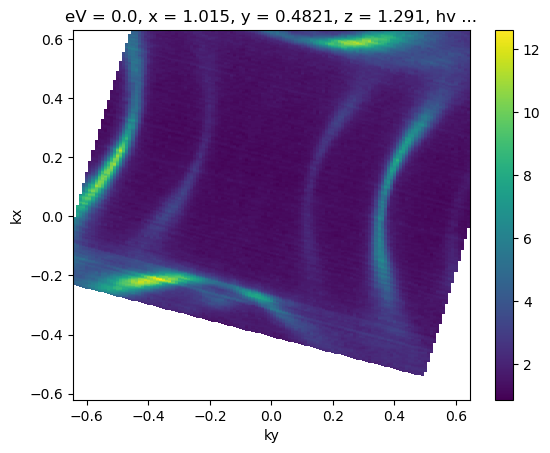

In [37]:
k_data.S.plot()

In [ ]:
plt.figure()

plt.pcolormesh( np.abs(np.fft.fft2(np.array(binned))), vmin = 0, vmax =1e4)